# Neural ratio estimation

This tutorial demonstrates how to perform neural ratio estimation (NRE) with `lampe`.

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader, H5Dataset
from lampe.distributions import BoxUniform
from lampe.inference import NRE, NRELoss, MetropolisHastings
from lampe.plots import nice_rc, corner
from lampe.utils import GDStep

## Simulator

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([ 0.2592, -0.2490,  0.0877])
tensor([0.1855, 0.0274])


In [3]:
loader = JointLoader(prior, simulator, batch_size=128, vectorized=True)

## Training

The principle of neural ratio estimation (NRE) is to train a classifier network $d_\phi(\theta, x)$ to distinguish between pairs $(\theta, x)$ equally sampled from the joint distribution $p(\theta, x)$ or from the product of the marginals $p(\theta) p(x)$. We use the [`NRE`](https://francois-rozet.github.io/lampe/api/inference.html#lampe.inference.NRE) class provided by the [`lampe.inference`](https://francois-rozet.github.io/lampe/api/inference.html) module to create a classifier network adapted to the simulator's input and output sizes. For numerical stability reasons, the created network returns the logit of the class prediction $\text{logit}(d_\phi(\theta, x)) = \log r_\phi(\theta, x)$.

In [4]:
estimator = NRE(3, 2, hidden_features=[64] * 5, activation='ELU')
estimator

NRE(
  (standardize): Identity()
  (net): MLP(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

Then, we train our classifier using a standard neural network training routine.

In [5]:
loss = NRELoss(estimator)
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(128), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta, x))
            for theta, x in islice(loader, 256)  # 256 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 128/128 [03:35<00:00,  1.68s/epoch, loss=0.0989]


## Inference

Now that we have an estimator of the likelihood-to-evidence (LTE) ratio $r(\theta, x) = \frac{p(\theta | x)}{p(\theta)}$, we can sample from the posterior distribution of an observation $x^*$ via MCMC or nested sampling. In our case, we use the [`MetropolisHastings`](https://francois-rozet.github.io/lampe/api/inference.html#lampe.inference.MetropolisHastings) sampler provided by the `lampe.inference` module.

In [6]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    theta_0 = prior.sample((4096,))  # 1024 concurrent Markov chains
    log_p = lambda theta: estimator(theta, x_star) + prior.log_prob(theta)  # p(theta | x) = r(theta, x) p(theta)

    sampler = MetropolisHastings(theta_0, log_f=log_p, sigma=0.5)
    samples = torch.cat([
        theta
        for theta in sampler(512 + 1024, burn=1024, step=4)
    ])

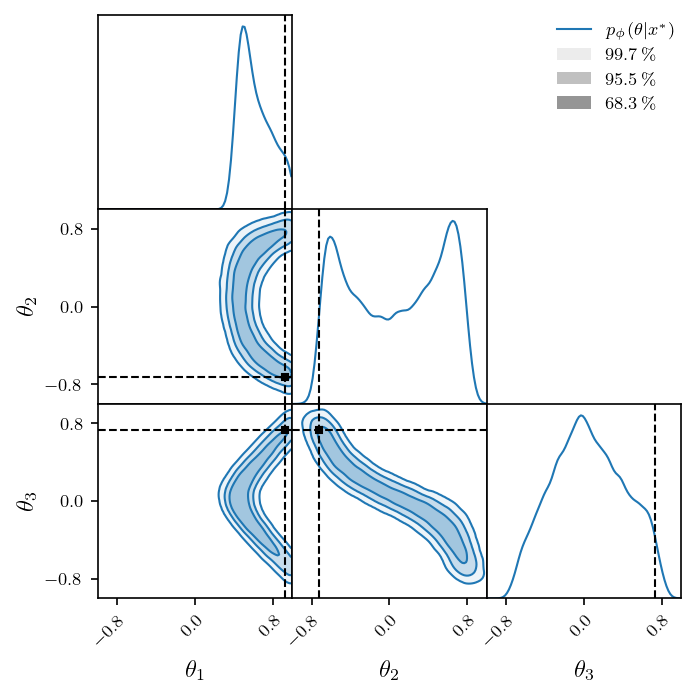

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    bounds=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    markers=[theta_star],
    figsize=(4.8, 4.8),
)